<a href="https://colab.research.google.com/github/sitifariya/phyton_project/blob/main/outbound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mesa==1.2.1

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ferry_schedule (5).csv to ferry_schedule (5).csv
Saving Final_Lane_Table_with_Clean_Vehicle_Type_Allocation.csv to Final_Lane_Table_with_Clean_Vehicle_Type_Allocation.csv
Saving freight_demand.csv to freight_demand.csv
Saving tourist_demand.csv to tourist_demand.csv


In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


freight_df = pd.read_csv("freight_demand.csv")
tourist_df = pd.read_csv("tourist_demand.csv")
lane_df = pd.read_csv("Final_Lane_Table_with_Clean_Vehicle_Type_Allocation.csv")

TRI_SPEED_MIN, TRI_SPEED_MODE, TRI_SPEED_MAX = 10, 15, 20  # km/h
DIST_BUFFER_TO_PAF = 450
DIST_PAF_TO_MERGE = 160
DIST_MERGE_TO_BIG = 480
DIST_BIG_TO_CHECKIN = 800
FREIGHT_LENGTH = 17
TOURIST_LENGTH = 4.5
BUFFER_LANE_LENGTH = 450

class VehicleAgent(Agent):
    def __init__(self, unique_id, model, vehicle_type, operator):
        super().__init__(unique_id, model)
        self.vehicle_type = vehicle_type
        self.operator = operator
        self.speed = random.triangular(TRI_SPEED_MIN, TRI_SPEED_MODE, TRI_SPEED_MAX)
        self.total_time = 0

class PortOfDoverModel(Model):
    def __init__(self, freight_df, tourist_df, lane_df):
        self.schedule = RandomActivation(self)
        self.buffer_lanes = {lane: [] for lane in 'ABCDEFGHIJKLM'}
        self.paf_freight = {'PAF_F_1': [], 'PAF_F_2': [], 'PAF_F_3': []}
        self.paf_tourist = {'PAF_T_1': [], 'PAF_T_2': [], 'PAF_T_3': []}
        self.ferry_checkin_queues = {f'Booth_{i}': [] for i in range(1, 32)}
        self.completed_agents = []

        self.lane_df = lane_df
        self.assembly_lanes = {row['Lane_ID']: {'freight': 0, 'tourist': 0} for _, row in lane_df.iterrows()}
        self.assembly_lane_utilization = {row['Lane_ID']: 0 for _, row in lane_df.iterrows()}

        # Utilizations
        self.buffer_lane_utilization = {lane: 0 for lane in 'ABCDEFGHIJKLM'}
        self.paf_utilization = {**{k: 0 for k in self.paf_freight}, **{k: 0 for k in self.paf_tourist}}
        self.ferry_utilization = {k: 0 for k in self.ferry_checkin_queues}

        # Queue
        self.buffer_queue_time = {lane: [] for lane in 'ABCDEFGHIJKLM'}
        self.paf_queue_time = {**{k: [] for k in self.paf_freight}, **{k: [] for k in self.paf_tourist}}
        self.ferry_queue_time = {k: [] for k in self.ferry_checkin_queues}

        self.freight_lane_capacity = int(BUFFER_LANE_LENGTH / FREIGHT_LENGTH)
        self.tourist_lane_capacity = int(BUFFER_LANE_LENGTH / TOURIST_LENGTH)

        self.agent_id_counter = 0
        self.generate_agents(freight_df, 'freight')
        self.generate_agents(tourist_df, 'tourist')

    def generate_agents(self, df, vehicle_type):
        for _, row in df.iterrows():
            for op in ['DFDS', 'IRISH_FERRY', 'P&O']:
                for _ in range(int(row.get(op, 0))):
                    agent = VehicleAgent(self.agent_id_counter, self, vehicle_type, op)
                    self.schedule.add(agent)
                    if vehicle_type == 'freight':
                        possible = [l for l in 'ABCDEFG' if len(self.buffer_lanes[l]) < self.freight_lane_capacity]
                    else:
                        possible = [l for l in 'HIJKLM' if len(self.buffer_lanes[l]) < self.tourist_lane_capacity]

                    if possible:
                        if random.random() < 0.:
                            # 80% choose lane with fewest vehicles
                            lane = min(possible, key=lambda l: len(self.buffer_lanes[l]))
                        else:
                            # 20% random lane
                            lane = random.choice(possible)

                        self.buffer_lanes[lane].append(agent)
                        self.buffer_lane_utilization[lane] += 1
                        self.buffer_queue_time[lane].append(len(self.buffer_lanes[lane]))

                    self.agent_id_counter += 1


    def assign_checkin(self, agent):
        if agent.operator == 'IRISH_FERRY':
            return random.choice(['Booth_1', 'Booth_2', 'Booth_3']) if agent.vehicle_type == 'freight' else random.choice(['Booth_4', 'Booth_5', 'Booth_6'])
        elif agent.operator == 'DFDS':
            return random.choice(['Booth_7', 'Booth_8', 'Booth_9', 'Booth_10', 'Booth_11', 'Booth_12']) if agent.vehicle_type == 'freight' else random.choice(['Booth_13', 'Booth_14', 'Booth_15', 'Booth_16', 'Booth_17', 'Booth_18'])
        else:
            return random.choice(['Booth_19', 'Booth_20', 'Booth_21', 'Booth_22', 'Booth_23', 'Booth_24', 'Booth_25']) if agent.vehicle_type == 'freight' else random.choice(['Booth_26', 'Booth_27', 'Booth_28', 'Booth_29', 'Booth_30'])

    def run_model(self):
        for lane, queue in self.buffer_lanes.items():
            for agent in queue:
                agent.total_time += DIST_BUFFER_TO_PAF / (agent.speed * 1000 / 3600)
                self.buffer_queue_time[lane].append(len(queue))
                paf = min(self.paf_freight if agent.vehicle_type == 'freight' else self.paf_tourist,
                          key=lambda k: len(self.paf_freight[k] if agent.vehicle_type == 'freight' else self.paf_tourist[k]))
                if agent.vehicle_type == 'freight':
                    self.paf_freight[paf].append(agent)
                else:
                    self.paf_tourist[paf].append(agent)
                self.paf_utilization[paf] += 1

        for paf_dict, process_time in [(self.paf_freight, 420), (self.paf_tourist, 120)]:
            for booth, queue in paf_dict.items():
                for agent in queue:
                    agent.total_time += process_time
                    booth_id = self.assign_checkin(agent)
                    self.ferry_checkin_queues[booth_id].append(agent)
                    self.ferry_utilization[booth_id] += 1
                self.paf_queue_time[booth].append(len(queue))

        for booth, queue in self.ferry_checkin_queues.items():
            self.ferry_queue_time[booth].append(len(queue))
            for agent in queue:
                agent.total_time += 180 if agent.vehicle_type == 'freight' else 60
                self.completed_agents.append(agent)

# === Run the model ===
model = PortOfDoverModel(freight_df, tourist_df, lane_df)
model.run_model()

print(f"Completed agents: {len(model.completed_agents)}")

Completed agents: 782


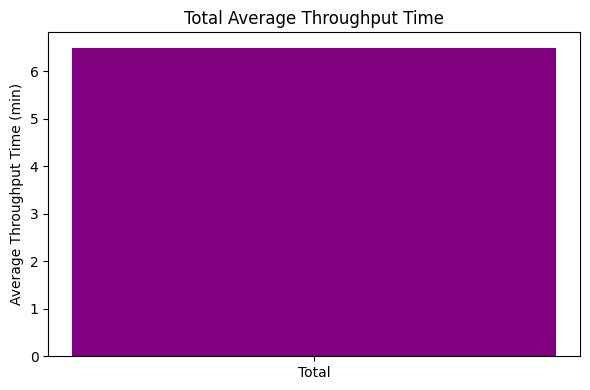

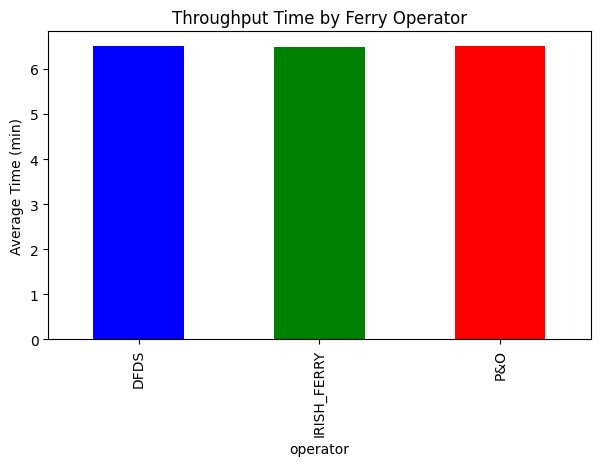

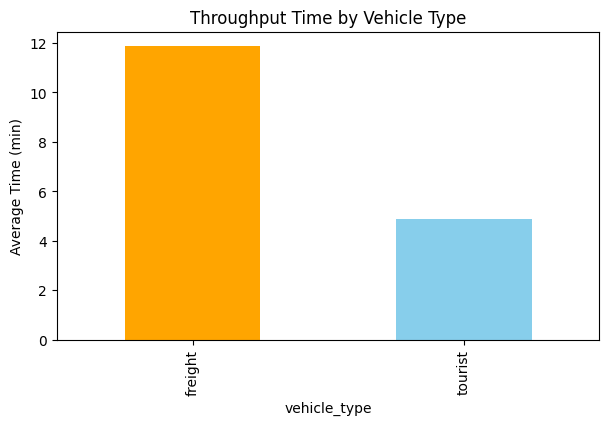

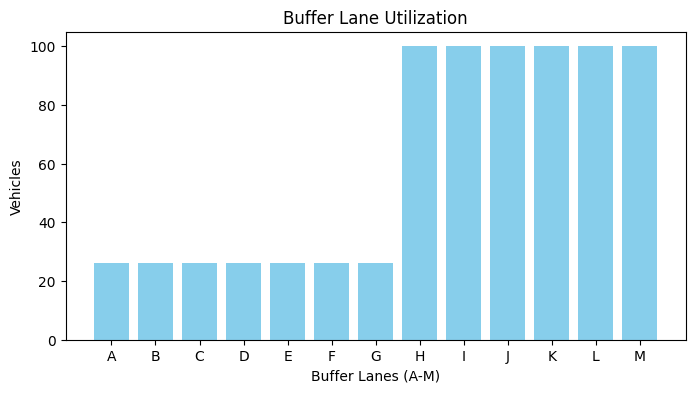

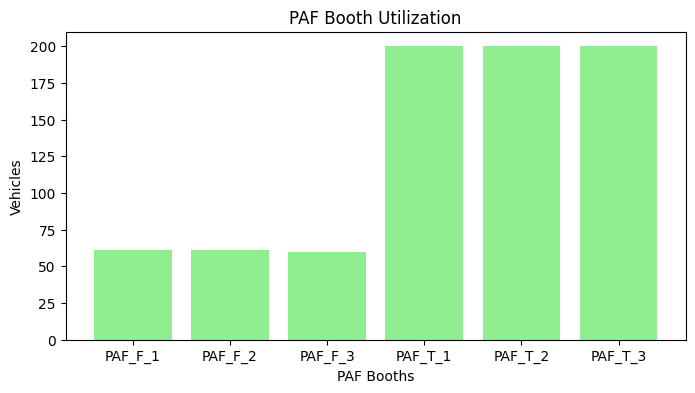

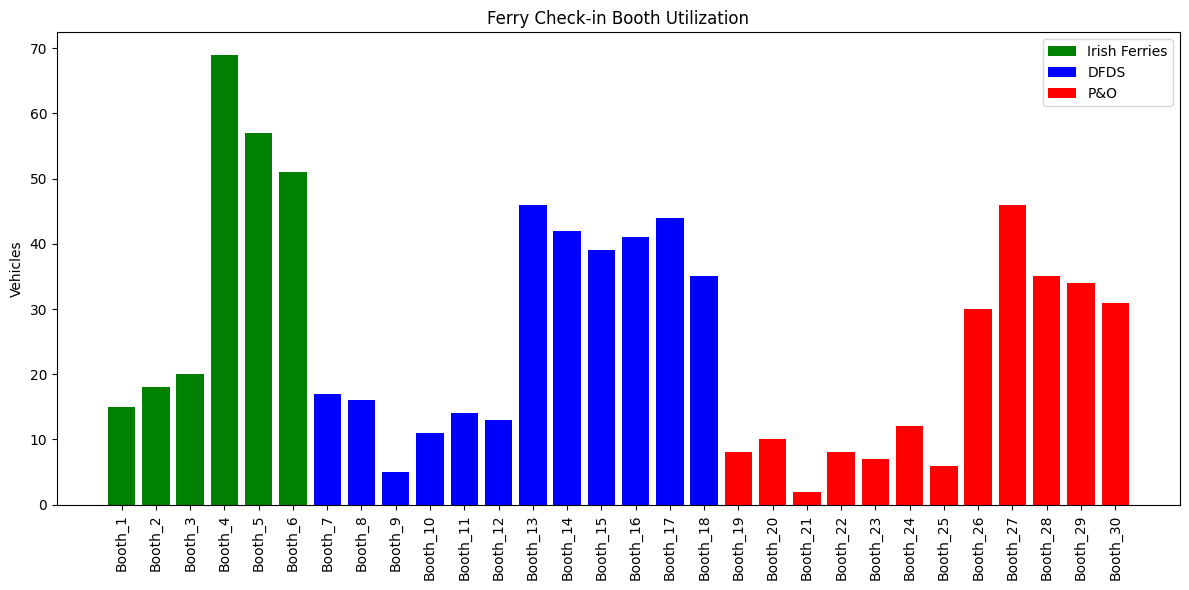

In [ ]:
agent_data = pd.DataFrame([
    {'vehicle_type': agent.vehicle_type, 'operator': agent.operator, 'total_time': agent.total_time}
    for agent in model.completed_agents
])
agent_data['total_time'] = agent_data['total_time'] / 60

plt.figure(figsize=(6, 4))
plt.bar(["Total"], [agent_data["total_time"].mean()], color='purple')
plt.ylabel("Average Throughput Time (min)")
plt.title("Total Average Throughput Time")
plt.tight_layout()
plt.show()

# By Operator
agent_data.groupby("operator")["total_time"].mean().plot(kind='bar', color=['blue', 'green', 'red'], figsize=(7, 4))
plt.ylabel("Average Time (min)")
plt.title("Throughput Time by Ferry Operator")
plt.show()

# By Vehicle Type
agent_data.groupby("vehicle_type")["total_time"].mean().plot(kind='bar', color=['orange', 'skyblue'], figsize=(7, 4))
plt.ylabel("Average Time (min)")
plt.title("Throughput Time by Vehicle Type")
plt.show()

# Buffer Lane Utilization
plt.figure(figsize=(8, 4))
plt.bar(model.buffer_lane_utilization.keys(), model.buffer_lane_utilization.values(), color='skyblue')
plt.xlabel("Buffer Lanes (A-M)")
plt.ylabel("Vehicles")
plt.title("Buffer Lane Utilization")
plt.show()

# PAF Booth Utilization
plt.figure(figsize=(8, 4))
plt.bar(model.paf_utilization.keys(), model.paf_utilization.values(), color='lightgreen')
plt.xlabel("PAF Booths")
plt.ylabel("Vehicles")
plt.title("PAF Booth Utilization")
plt.show()

# Ferry Check-in Booth Utilization
plt.figure(figsize=(12, 6))
irish_booths = [f'Booth_{i}' for i in [1, 2, 3, 4, 5, 6]]
dfds_booths = [f'Booth_{i}' for i in range(7, 19)]
po_booths = [f'Booth_{i}' for i in range(19, 31)]

plt.bar(irish_booths, [model.ferry_utilization[b] for b in irish_booths], color='green', label='Irish Ferries')
plt.bar(dfds_booths, [model.ferry_utilization[b] for b in dfds_booths], color='blue', label='DFDS')
plt.bar(po_booths, [model.ferry_utilization[b] for b in po_booths], color='red', label='P&O')
plt.legend()
plt.xticks(rotation=90)
plt.ylabel("Vehicles")
plt.title("Ferry Check-in Booth Utilization")
plt.tight_layout()
plt.show()




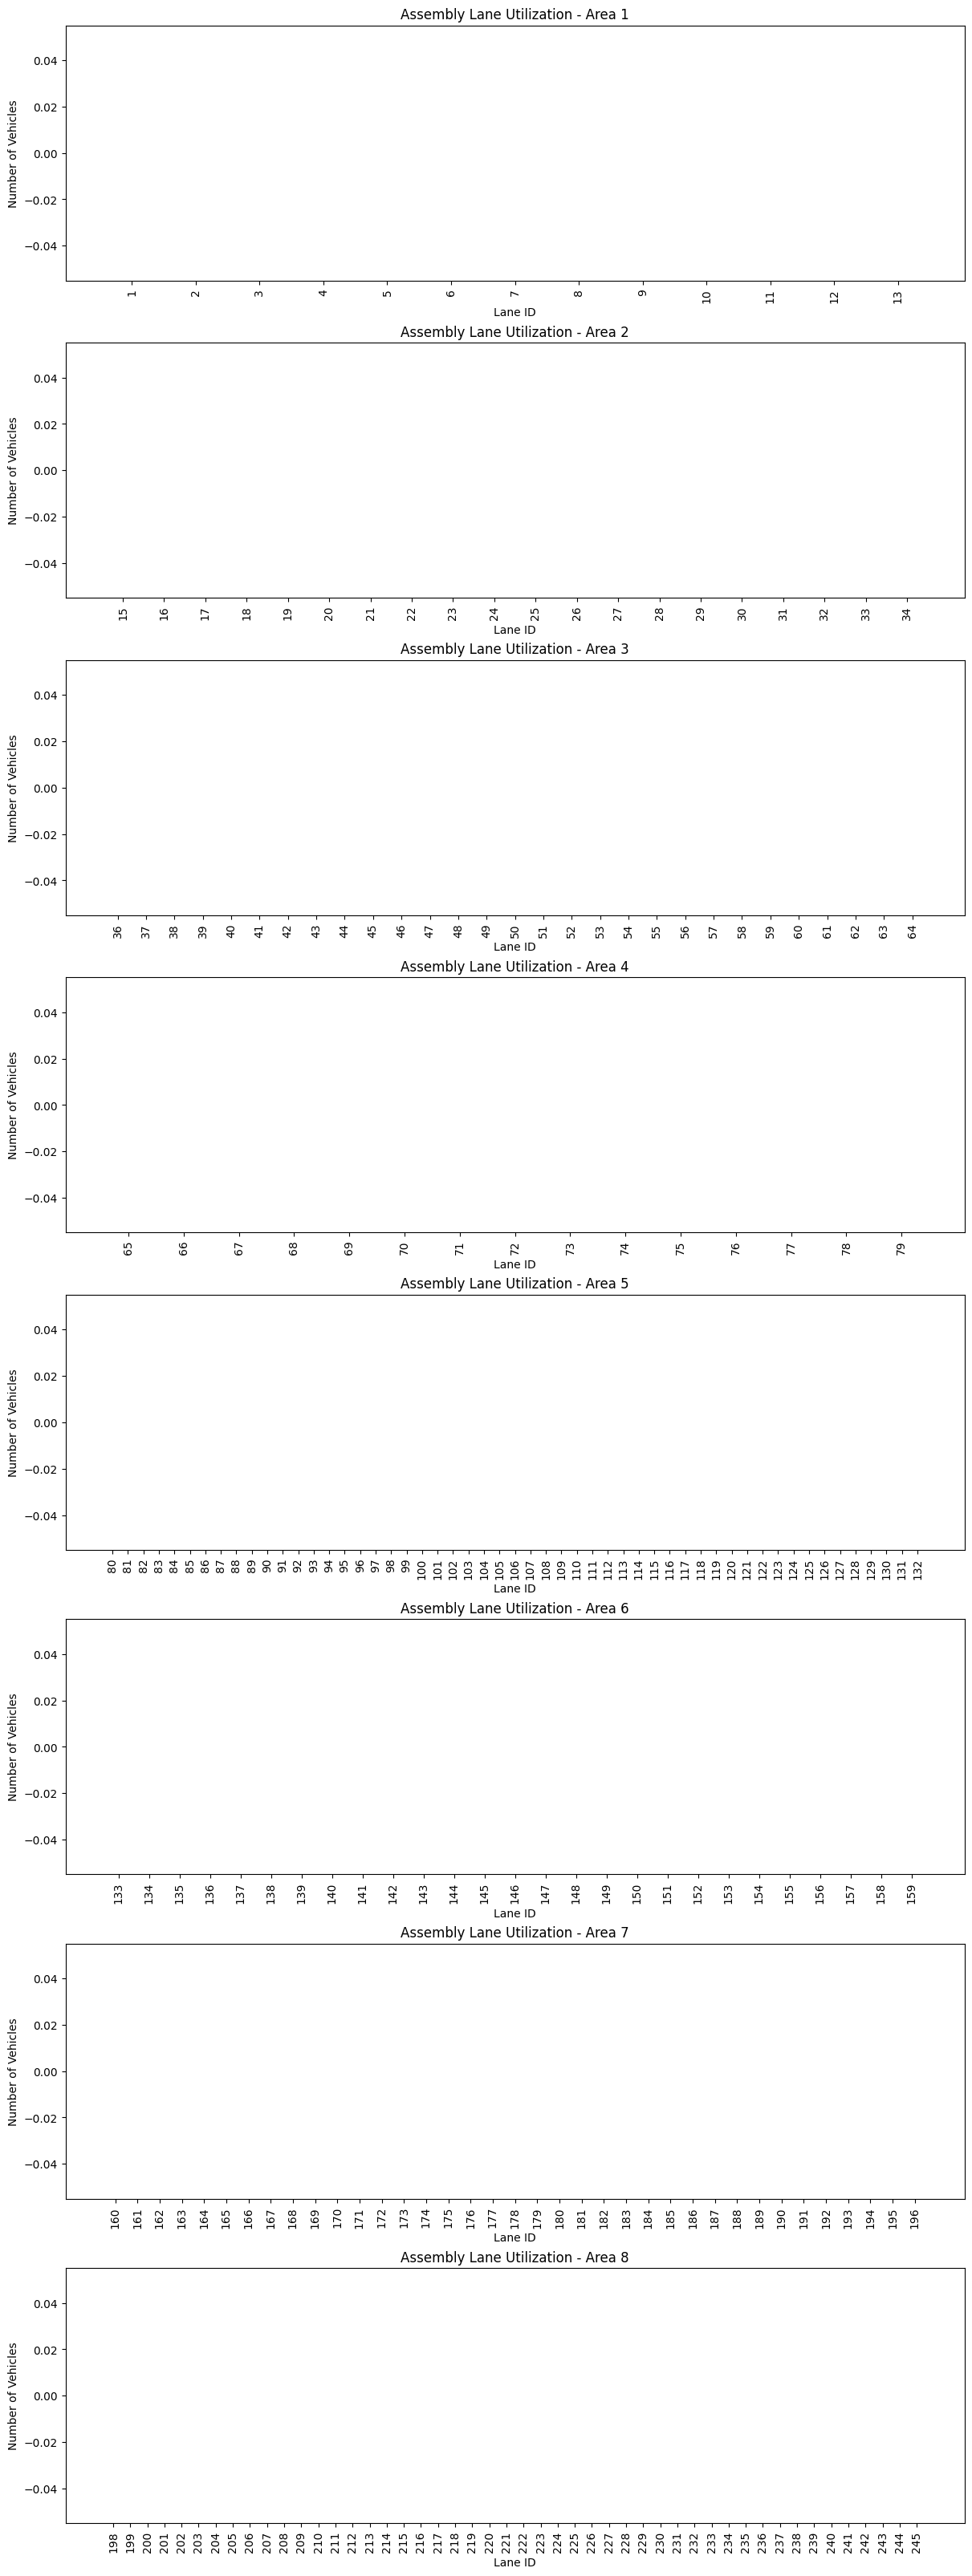

In [ ]:

area_grouped = lane_df.groupby('Area')


unique_areas = sorted(lane_df['Area'].unique())
num_areas = len(unique_areas)

fig, axes = plt.subplots(num_areas, 1, figsize=(12, 4 * num_areas), constrained_layout=True)


if num_areas == 1:
    axes = [axes]


for idx, area in enumerate(unique_areas):
    area_lanes = area_grouped.get_group(area)['Lane_ID'].tolist()
    lane_counts = {lane: model.assembly_lane_utilization.get(lane, 0) for lane in area_lanes}

    axes[idx].bar([str(lane) for lane in lane_counts.keys()], lane_counts.values(), color='darkcyan')
    axes[idx].set_title(f"Assembly Lane Utilization - Area {area}")
    axes[idx].set_xlabel("Lane ID")
    axes[idx].set_ylabel("Number of Vehicles")
    axes[idx].tick_params(axis='x', rotation=90)

plt.show()


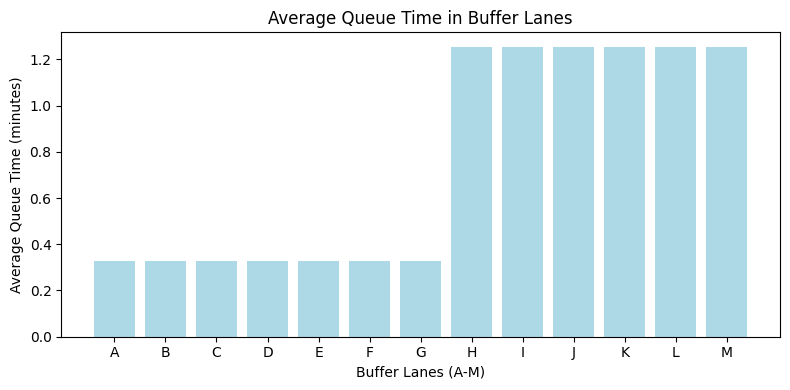

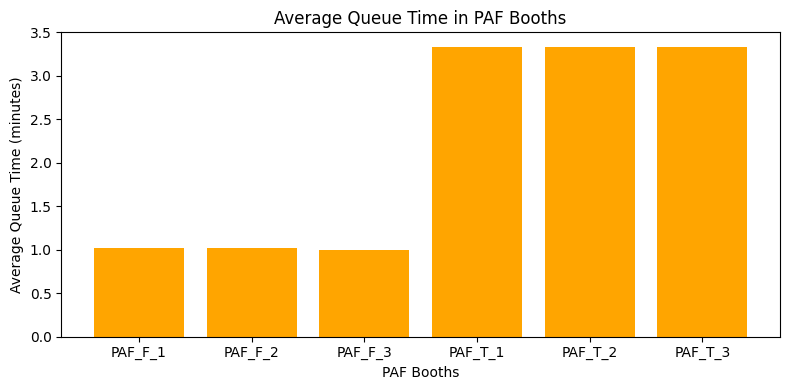

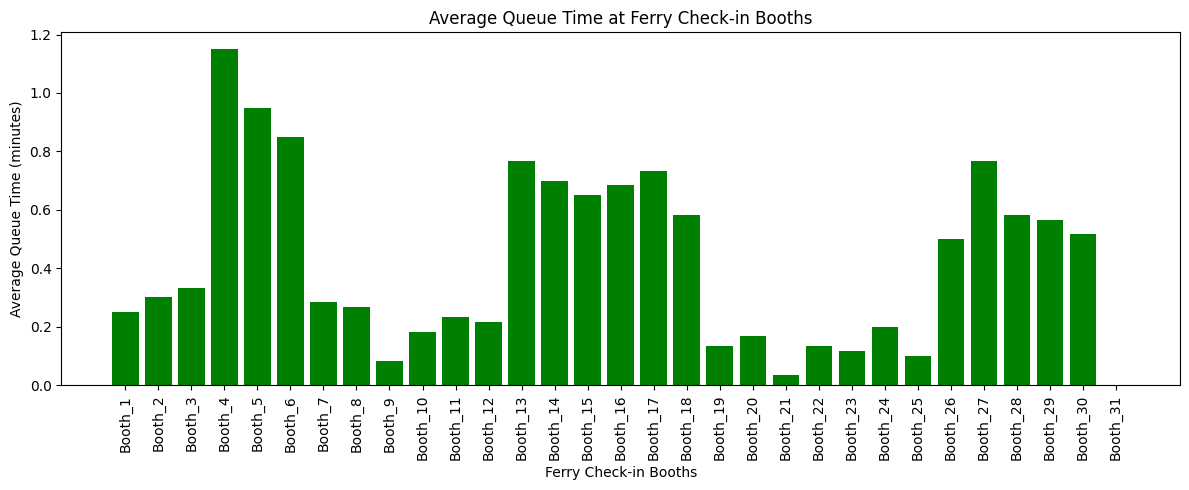

In [ ]:
import matplotlib.pyplot as plt

# QUEUE TIME IN BUFFER ZONE
buffer_avg_queue_minutes = {lane: (sum(times) / len(times) / 60) if times else 0
                            for lane, times in model.buffer_queue_time.items()}
plt.figure(figsize=(8, 4))
plt.bar(buffer_avg_queue_minutes.keys(), buffer_avg_queue_minutes.values(), color='lightblue')
plt.xlabel('Buffer Lanes (A-M)')
plt.ylabel('Average Queue Time (minutes)')
plt.title('Average Queue Time in Buffer Lanes')
plt.tight_layout()
plt.show()

# QUEUEU TIME IN PAF
paf_avg_queue_minutes = {booth: (sum(times) / len(times) / 60) if times else 0
                         for booth, times in model.paf_queue_time.items()}
plt.figure(figsize=(8, 4))
plt.bar(paf_avg_queue_minutes.keys(), paf_avg_queue_minutes.values(), color='orange')
plt.xlabel('PAF Booths')
plt.ylabel('Average Queue Time (minutes)')
plt.title('Average Queue Time in PAF Booths')
plt.tight_layout()
plt.show()

# QUEUEU TIME IN FERRY CHECK-IN
ferry_avg_queue_minutes = {booth: (sum(times) / len(times) / 60) if times else 0
                           for booth, times in model.ferry_queue_time.items()}
plt.figure(figsize=(12, 5))
plt.bar(ferry_avg_queue_minutes.keys(), ferry_avg_queue_minutes.values(), color='green')
plt.xticks(rotation=90)
plt.xlabel('Ferry Check-in Booths')
plt.ylabel('Average Queue Time (minutes)')
plt.title('Average Queue Time at Ferry Check-in Booths')
plt.tight_layout()
plt.show()


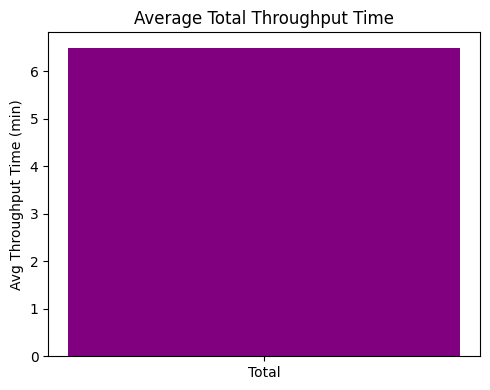

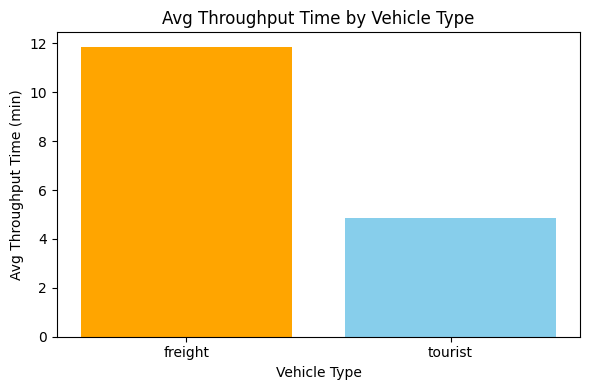

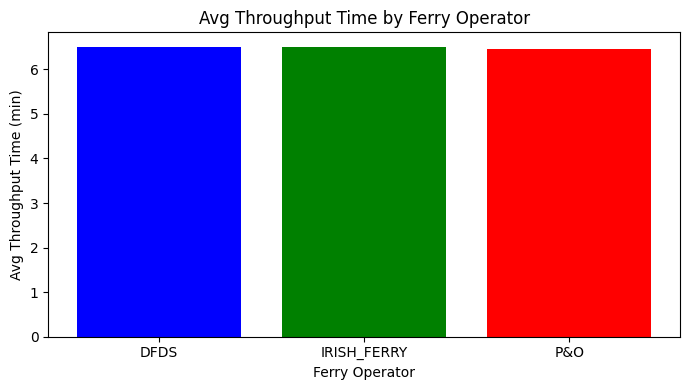

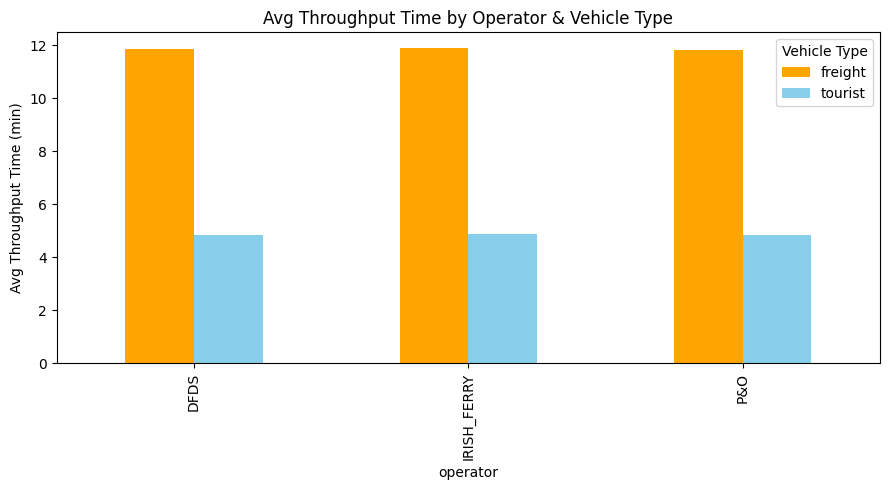

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect Completed Agents' Data
agent_data = pd.DataFrame([{
    'vehicle_type': agent.vehicle_type,
    'operator': agent.operator,
    'total_time_min': agent.total_time / 60  # convert to minutes
} for agent in model.completed_agents])

# Average Total Throughput Time Bar
plt.figure(figsize=(5, 4))
plt.bar(["Total"], [agent_data["total_time_min"].mean()], color='purple')
plt.ylabel("Avg Throughput Time (min)")
plt.title("Average Total Throughput Time")
plt.tight_layout()
plt.show()

# Average Throughput by Vehicle Type (Freight vs Tourist)
avg_vehicle = agent_data.groupby('vehicle_type')["total_time_min"].mean()
plt.figure(figsize=(6, 4))
plt.bar(avg_vehicle.index, avg_vehicle.values, color=['orange', 'skyblue'])
plt.xlabel("Vehicle Type")
plt.ylabel("Avg Throughput Time (min)")
plt.title("Avg Throughput Time by Vehicle Type")
plt.tight_layout()
plt.show()

# Average Throughput by Ferry Operator
avg_operator = agent_data.groupby('operator')["total_time_min"].mean()
plt.figure(figsize=(7, 4))
plt.bar(avg_operator.index, avg_operator.values, color=['blue', 'green', 'red'])
plt.xlabel("Ferry Operator")
plt.ylabel("Avg Throughput Time (min)")
plt.title("Avg Throughput Time by Ferry Operator")
plt.tight_layout()
plt.show()

# Average Throughput by Operator & Vehicle Type
grouped = agent_data.groupby(['operator', 'vehicle_type'])["total_time_min"].mean().unstack()
grouped.plot(kind='bar', figsize=(9, 5), color={'freight': 'orange', 'tourist': 'skyblue'})
plt.ylabel("Avg Throughput Time (min)")
plt.title("Avg Throughput Time by Operator & Vehicle Type")
plt.legend(title='Vehicle Type')
plt.tight_layout()
plt.show()
